In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [2]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 14,
  "grid.alpha": 0.25})

### Function declarations

In [4]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
                     use_weekday_locator=False, use_year_locator=True, title=None, 
                     add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%d-%b")
    locator = mdates.DayLocator(interval=14)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

In [5]:
def plot_time_series_data_window(
  x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
  use_weekday_locator=False, use_year_locator=True, title=None, 
  add_mark_at=None, input_width=24, label_width=24):

  fig, ax = plt.subplots(figsize=figsize)

  num_of_rows = len(x)
  data_window_size = input_width + label_width
  num_of_data_window = num_of_rows // data_window_size
  input_color = "tab:blue" 
  label_color = "tab:orange" 
  
  for i in range(num_of_data_window):
    start_width_idx = i*data_window_size
    end_width_idx = i*data_window_size + input_width
    ax.plot(x.iloc[start_width_idx:end_width_idx], 
            y.iloc[start_width_idx:end_width_idx], color=input_color, 
            marker="s")
    
    start_label_idx = i*data_window_size + input_width
    end_label_idx = i*data_window_size + input_width + label_width
    ax.plot(x.iloc[start_label_idx:end_label_idx], 
            y.iloc[start_label_idx:end_label_idx], color=label_color, 
            marker="x")
        
  if use_weekday_locator:
    formatter = mdates.DateFormatter("%d-%b")
    locator = mdates.DayLocator(interval=14)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

### Load

In [6]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [7]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [8]:
df_cdb_with_tipe = df_cdb_with_initial.copy()
def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_individu = df_cdb_with_tipe[df_cdb_with_tipe["Tipe Pembeli"] == "INDIVIDU"].copy()
df_cdb_individu

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


In [9]:
df_G = df_cdb_individu[df_cdb_individu["initial Varian Plus"] == "G"].copy()
df_G

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
22,2021-01-07,SUMINI,BABULU DARAT,BABULU DARAT,BABULU,PEREMPUAN,1978-12-07,Wiraswasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GB3,G,INDIVIDU,46
99,2021-01-27,BUDI,JL PERUM POLDA,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1974-02-01,LAIN-LAIN,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GF4,G,INDIVIDU,51
102,2021-01-28,"SAIPUL HOLIS, SE",JL SYARIFUDDIN YOES,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1969-10-18,Pegawai Swasta-Jasa,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SARJANA,GF4,G,INDIVIDU,55
172,2021-02-22,SULATI,JL BUKIT PELAJAR,BARU TENGAH,BALIKPAPAN BARAT,PEREMPUAN,1972-02-27,Wiraswasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GB3,G,INDIVIDU,53
288,2021-03-23,SARINAH,BULUMINUNG,BULUMINUNG,PENAJAM,PEREMPUAN,1980-12-01,Pegawai Swasta-Pertanian,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,GF4,G,INDIVIDU,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6780,2024-08-21,PT JAYACOM PERSADA MANDIRI,JL MT HARYONO,GUNUNG BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,2003-01-01,Wiraswasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GD4,G,INDIVIDU,22
6790,2024-08-22,PT. ARKANANTA APTA PRATISTA,JL MT HARYONO,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,2006-08-22,Wiraswasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GD4,G,INDIVIDU,18
6794,2024-08-23,AGUSWANTO,JL.SULAWESI,KARANG REJO,BALIKPAPAN TENGAH,LAKI-LAKI,1972-07-08,Pegawai Swasta-Jasa,"> Rp. 6.000.000,-",SLTA/SMU,GF5,G,INDIVIDU,52
6803,2024-08-24,HENDRA TAMBA,JL KOLONEL SYARIFUDDIN YOES,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1990-01-05,MAHASISWA/PELAJAR,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,GD4,G,INDIVIDU,35


In [10]:
df_G_count = df_G[["Tgl. Mohon"]].copy()
df_G_count["count"] = 1.
df_G_count = df_G_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_G_count["cumulative_sum"] = df_G_count["count"].cumsum()
df_G_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-07,1,1
1,2021-01-27,1,2
2,2021-01-28,1,3
3,2021-02-22,1,4
4,2021-03-23,1,5
...,...,...,...
165,2024-08-21,1,187
166,2024-08-22,1,188
167,2024-08-23,1,189
168,2024-08-24,1,190


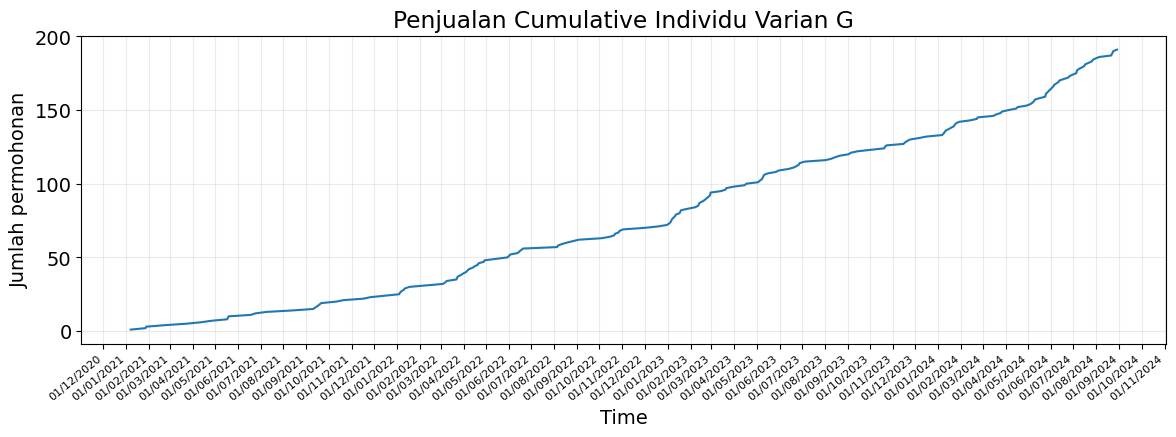

In [11]:
plot_time_series(df_G_count["Tgl. Mohon"], df_G_count["cumulative_sum"], use_year_locator=True, 
                  ylabel="Jumlah permohonan", title="Penjualan Cumulative Individu Varian G")

## Feature engineering

In [12]:
df_G_count.describe()

,Tgl. Mohon,count,cumulative_sum
count,170,170.000000,170.000000
mean,2023-03-04 09:44:28.235294208,1.123529,94.176471
min,2021-01-07 00:00:00,1.000000,1.000000
25%,2022-04-20 06:00:00,1.000000,45.250000
50%,2023-03-17 00:00:00,1.000000,95.500000
75%,2024-01-28 00:00:00,1.000000,141.750000
max,2024-08-29 00:00:00,3.000000,191.000000
std,NaN,0.380018,55.496506


- Karena `count` mayoritas tanggal hanya memiliki 1 unit penjualan dan maksimal 3 unit terjual
- Kolom `cumulative_sum` tidak cocok untuk digunakan langsung dalam prediksi karena secara definisi selalu meningkat namun bisa digunakan untuk membuat fitur baru seperti jumlah permohonan dalam periode tertentu (sliding window) atau perubahan kumulatif
- Encoding waktu ke bentuk sin dan cos agar model dapat mengenali pola musiman

yang dilakukan
1. Mengurutkan data berdasarkan tanggal permohonan untuk rolling window
2. Menambah fitur baru:
    - `rolling_7days` untuk jumlah permohonan dalam 7 hari terakhir
    - `rolling_std_7d` untuk melihat fluktuasi permohonan dalam 7 hari terakhir
    - `rolling_count_7d` untuk melihat jumlah pemohon aktif tiap 7 hari 
    - `delta_count` untuk melihat selisih jumlah permohonan di hari sebelumnya
    - `month` untuk melihat pola data lebih banyak di bulan apa
    - `weekday` untuk melihat pola data lebih banyak di awal atau alhir minggu
3. Encoding fitur waktu dengan menambah fitur baru
    - `month_sin` dan `month_cos` untuk merepresentasikan nilai bulan Jan = 1 sampai Des = 12 secara periodik (siklikal), misalnya untuk menangani bulan Des (12) ke Jan (1) berdekatan dalam waktu, namun secara numerik 12 dan 1 terlihat jauh karena model tidak mengerti bahwa bulan itu berulang
    - `weekday_sin` dan `weekday_cos` untuk merepresentasikan hari dalam mingguan Senin = 0, Minggu = 6 secara siklikal
sehingga dengan sinus dan cosinus dapat membuat cyclical encoding (lingkaran) agar model bisa menangkap pola berulang karena berada pada sudut yang mirip di lingkaran. 

### Add Fitur

In [13]:
df_G_rolling = df_G_count.copy()
df_G_rolling = df_G_rolling.sort_values("Tgl. Mohon").reset_index(drop=True)

df_G_rolling["rolling_7days"] = df_G_rolling["count"].rolling(window=7, min_periods=1).sum()
df_G_rolling['rolling_std_7d'] = df_G_rolling['count'].rolling(window=7, min_periods=1).std().fillna(0)
df_G_rolling["rolling_count_7d"] = df_G_rolling["count"].rolling(window=7, min_periods=1).count()
df_G_rolling['delta_count'] = df_G_rolling['count'].diff().fillna(0)

df_G_rolling['month'] = df_G_rolling['Tgl. Mohon'].dt.month
df_G_rolling['weekday'] = df_G_rolling['Tgl. Mohon'].dt.weekday
df_G_rolling

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday
0,2021-01-07,1,1,1.0,0.000000,1.0,0.0,1,3
1,2021-01-27,1,2,2.0,0.000000,2.0,0.0,1,2
2,2021-01-28,1,3,3.0,0.000000,3.0,0.0,1,3
3,2021-02-22,1,4,4.0,0.000000,4.0,0.0,2,0
4,2021-03-23,1,5,5.0,0.000000,5.0,0.0,3,1
...,...,...,...,...,...,...,...,...,...
165,2024-08-21,1,187,8.0,0.377964,7.0,0.0,8,2
166,2024-08-22,1,188,8.0,0.377964,7.0,0.0,8,3
167,2024-08-23,1,189,8.0,0.377964,7.0,0.0,8,4
168,2024-08-24,1,190,7.0,0.000000,7.0,0.0,8,5


### Encoding Fitur Waktu (sin cos)

In [14]:
df_G_rolling['month_sin'] = np.sin(2 * np.pi * df_G_rolling['month'] / 12)
df_G_rolling['month_cos'] = np.cos(2 * np.pi * df_G_rolling['month'] / 12)

df_G_rolling['weekday_sin'] = np.sin(2 * np.pi * df_G_rolling['weekday'] / 7)
df_G_rolling['weekday_cos'] = np.cos(2 * np.pi * df_G_rolling['weekday'] / 7)
df_G_rolling

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-07,1,1,1.0,0.000000,1.0,0.0,1,3,0.500000,8.660254e-01,0.433884,-0.900969
1,2021-01-27,1,2,2.0,0.000000,2.0,0.0,1,2,0.500000,8.660254e-01,0.974928,-0.222521
2,2021-01-28,1,3,3.0,0.000000,3.0,0.0,1,3,0.500000,8.660254e-01,0.433884,-0.900969
3,2021-02-22,1,4,4.0,0.000000,4.0,0.0,2,0,0.866025,5.000000e-01,0.000000,1.000000
4,2021-03-23,1,5,5.0,0.000000,5.0,0.0,3,1,1.000000,6.123234e-17,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2024-08-21,1,187,8.0,0.377964,7.0,0.0,8,2,-0.866025,-5.000000e-01,0.974928,-0.222521
166,2024-08-22,1,188,8.0,0.377964,7.0,0.0,8,3,-0.866025,-5.000000e-01,0.433884,-0.900969
167,2024-08-23,1,189,8.0,0.377964,7.0,0.0,8,4,-0.866025,-5.000000e-01,-0.433884,-0.900969
168,2024-08-24,1,190,7.0,0.000000,7.0,0.0,8,5,-0.866025,-5.000000e-01,-0.974928,-0.222521


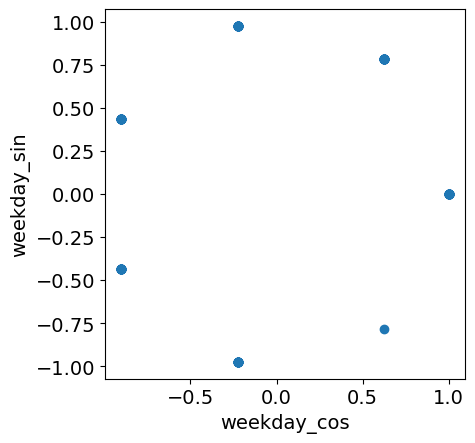

In [15]:
n_sample = 150   # randomly sample from the df_G_rolling

fig, ax = plt.subplots()

sampled_data = df_G_rolling.sample(n_sample)
ax.plot(sampled_data["weekday_cos"], sampled_data["weekday_sin"], linestyle="none",
        marker="o")

ax.set_aspect("equal")
ax.set_xlabel("weekday_cos")
ax.set_ylabel("weekday_sin")
plt.show(fig)

In [16]:
df_G_rolling.describe()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
count,170,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,1.700000e+02,170.000000,170.000000
mean,2023-03-04 09:44:28.235294208,1.123529,94.176471,7.741176,0.234004,6.876471,0.000000,5.388235,2.358824,0.137447,-9.942308e-02,0.172729,-0.062601
min,2021-01-07 00:00:00,1.000000,1.000000,1.000000,0.000000,1.000000,-2.000000,1.000000,0.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969
25%,2022-04-20 06:00:00,1.000000,45.250000,7.000000,0.000000,7.000000,0.000000,3.000000,1.000000,-0.500000,-8.660254e-01,-0.433884,-0.900969
50%,2023-03-17 00:00:00,1.000000,95.500000,7.000000,0.000000,7.000000,0.000000,5.000000,2.000000,0.500000,-1.836970e-16,0.433884,-0.222521
75%,2024-01-28 00:00:00,1.000000,141.750000,8.000000,0.377964,7.000000,0.000000,8.000000,4.000000,0.866025,5.000000e-01,0.781831,0.623490
max,2024-08-29 00:00:00,3.000000,191.000000,12.000000,0.786796,7.000000,2.000000,12.000000,6.000000,1.000000,1.000000e+00,0.974928,1.000000
std,NaN,0.380018,55.496506,1.500713,0.278118,0.723265,0.474186,3.173836,1.704696,0.691403,7.063514e-01,0.661697,0.730835


In [17]:
# Menghitung korelasi antar kolom numerik
corr_matrix = df_G_rolling.corr()
print(corr_matrix)


                  Tgl. Mohon     count  cumulative_sum  rolling_7days  \
Tgl. Mohon          1.000000  0.103371        0.991039       0.384151   
count               0.103371  1.000000        0.104455       0.336534   
cumulative_sum      0.991039  0.104455        1.000000       0.359911   
rolling_7days       0.384151  0.336534        0.359911       1.000000   
rolling_std_7d      0.264217  0.384034        0.275278       0.839194   
rolling_count_7d    0.352892  0.055847        0.283294       0.580941   
delta_count        -0.004624  0.623899       -0.006521      -0.066521   
month               0.135251 -0.133212        0.139831      -0.047106   
weekday             0.090536 -0.141900        0.082013      -0.102260   
month_sin          -0.145284  0.069312       -0.165379      -0.002020   
month_cos          -0.222989 -0.039197       -0.279866      -0.188689   
weekday_sin        -0.062151  0.025030       -0.049941       0.055837   
weekday_cos         0.025702  0.161103        0.029

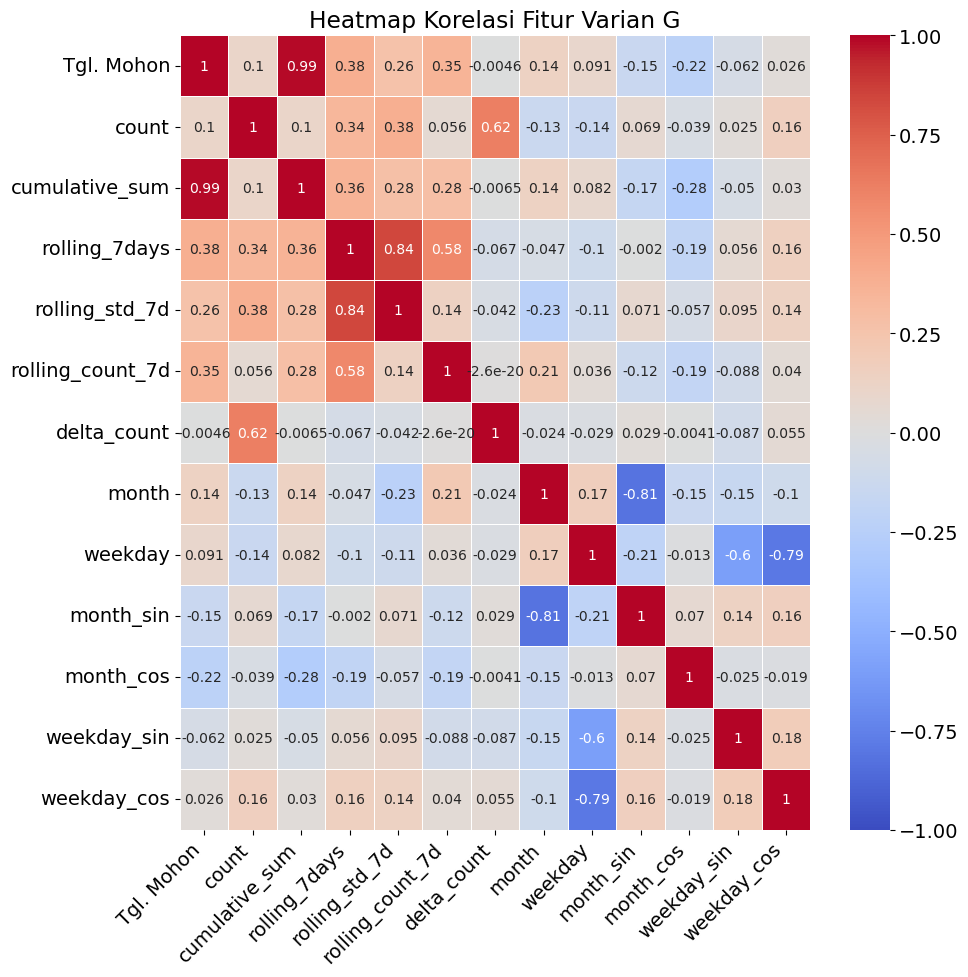

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5,
    vmin=-1, vmax=1, annot_kws={"size": 10})
plt.title("Heatmap Korelasi Fitur Varian G")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


### Data Splitting

In [19]:
n_data = len(df_G_rolling)

# Split 70:20:10 (train:validation:test)
idx_train = int(n_data * 0.7)
idx_test = int(n_data * 0.9)

train_df = df_G_rolling[:idx_train].copy()
val_df = df_G_rolling[idx_train:idx_test].copy()
test_df = df_G_rolling[idx_test:].copy()

print(f"len(train, val, test): {len(train_df), len(val_df), len(test_df)}")

len(train, val, test): (118, 35, 17)


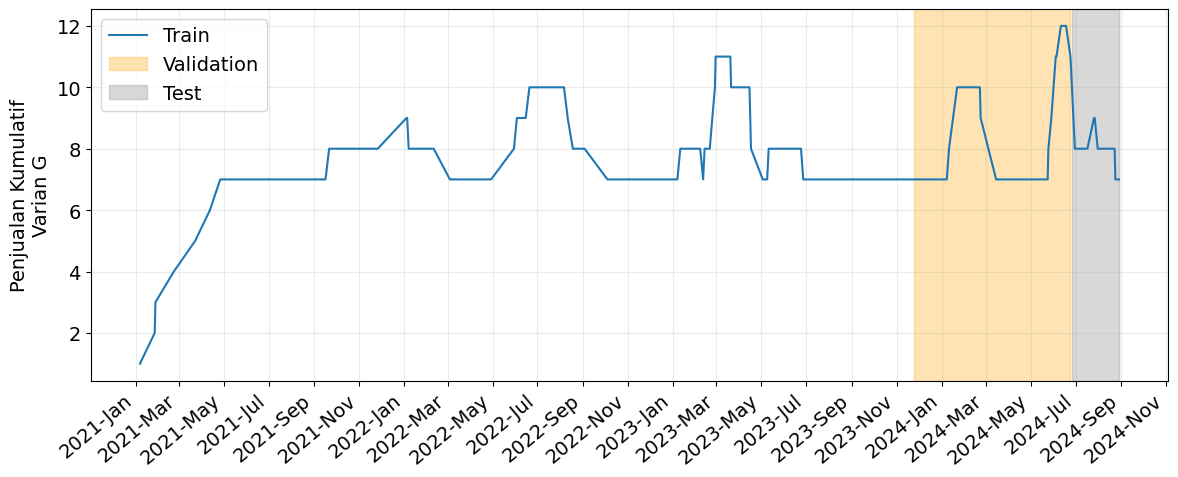

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_G_rolling['Tgl. Mohon'], df_G_rolling["rolling_7days"], label="Train", color="tab:blue")

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df['Tgl. Mohon'].iloc[0], test_df['Tgl. Mohon'].iloc[-1], 
           color="gray", alpha=0.3, label="Test")

ax.grid("on")
ax.set_ylabel("Penjualan Kumulatif\nVarian G")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

for label in ax.get_xticklabels():
    label.set_rotation(40)
    # label.set_fontsize(8)
    label.set_horizontalalignment('right')

ax.legend()

plt.tight_layout()
plt.show()

In [21]:
train_df

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-07,1,1,1.0,0.0,1.0,0.0,1,3,0.500000,8.660254e-01,0.433884,-0.900969
1,2021-01-27,1,2,2.0,0.0,2.0,0.0,1,2,0.500000,8.660254e-01,0.974928,-0.222521
2,2021-01-28,1,3,3.0,0.0,3.0,0.0,1,3,0.500000,8.660254e-01,0.433884,-0.900969
3,2021-02-22,1,4,4.0,0.0,4.0,0.0,2,0,0.866025,5.000000e-01,0.000000,1.000000
4,2021-03-23,1,5,5.0,0.0,5.0,0.0,3,1,1.000000,6.123234e-17,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2023-10-21,1,125,7.0,0.0,7.0,0.0,10,5,-0.866025,5.000000e-01,-0.974928,-0.222521
114,2023-10-23,1,126,7.0,0.0,7.0,0.0,10,0,-0.866025,5.000000e-01,0.000000,1.000000
115,2023-11-15,1,127,7.0,0.0,7.0,0.0,11,2,-0.500000,8.660254e-01,0.974928,-0.222521
116,2023-11-17,1,128,7.0,0.0,7.0,0.0,11,4,-0.500000,8.660254e-01,-0.433884,-0.900969


In [22]:
train_df.describe()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
count,118,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000
mean,2022-08-27 17:17:17.288135680,1.093220,64.796610,7.474576,0.187574,6.822034,0.000000,5.432203,2.279661,0.135593,3.324617e-03,0.186672,-0.054714
min,2021-01-07 00:00:00,1.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,1.000000,0.000000,-1.000000,-1.000000e+00,-0.974928,-0.900969
25%,2022-03-04 18:00:00,1.000000,32.250000,7.000000,0.000000,7.000000,0.000000,3.000000,1.000000,-0.774519,-5.000000e-01,-0.433884,-0.900969
50%,2022-10-18 00:00:00,1.000000,64.500000,7.000000,0.000000,7.000000,0.000000,5.000000,2.000000,0.500000,6.123234e-17,0.433884,-0.222521
75%,2023-04-11 06:00:00,1.000000,98.750000,8.000000,0.377964,7.000000,0.000000,8.000000,4.000000,0.866025,5.000000e-01,0.781831,0.623490
max,2023-11-20 00:00:00,3.000000,129.000000,11.000000,0.786796,7.000000,2.000000,12.000000,5.000000,1.000000,1.000000e+00,0.974928,1.000000
std,NaN,0.319917,38.136408,1.406407,0.245276,0.863617,0.413449,3.352455,1.683939,0.726957,6.793580e-01,0.645314,0.744281


scaling data

In [23]:
column_for_scaling = ["count", "cumulative_sum", "rolling_7days", "rolling_std_7d", 
                    "rolling_count_7d", "delta_count", "month", "weekday",
                    "month_sin", "month_cos", "weekday_sin", "weekday_cos"]

# Define a scaler object
scaler_obj = MinMaxScaler()
scaler_obj.fit(train_df[column_for_scaling])

# Scaling train, val, test
train_scale_df_g = train_df.copy()
val_scale_df_g = val_df.copy()
test_scale_df_g = test_df.copy()

train_scale_df_g[column_for_scaling] = scaler_obj.transform(train_scale_df_g[column_for_scaling])
val_scale_df_g[column_for_scaling] = scaler_obj.transform(val_scale_df_g[column_for_scaling])
test_scale_df_g[column_for_scaling] = scaler_obj.transform(test_scale_df_g[column_for_scaling])

display(train_scale_df_g.head())
display(val_scale_df_g.head())
display(test_scale_df_g.head())

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-07,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.000000,0.6,0.750000,0.933013,0.722521,5.551115e-17
1,2021-01-27,0.0,0.007812,0.1,0.0,0.166667,0.333333,0.000000,0.4,0.750000,0.933013,1.000000,3.568959e-01
2,2021-01-28,0.0,0.015625,0.2,0.0,0.333333,0.333333,0.000000,0.6,0.750000,0.933013,0.722521,5.551115e-17
3,2021-02-22,0.0,0.023438,0.3,0.0,0.500000,0.333333,0.090909,0.0,0.933013,0.750000,0.500000,1.000000e+00
4,2021-03-23,0.0,0.031250,0.4,0.0,0.666667,0.333333,0.181818,0.2,1.000000,0.500000,0.900969,8.019377e-01


,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
118,2023-11-24,0.0,1.007812,0.6,0.0,1.0,0.333333,0.909091,0.8,0.25,0.933013,0.277479,0.000000
119,2023-12-06,0.0,1.015625,0.6,0.0,1.0,0.333333,1.000000,0.4,0.50,1.000000,1.000000,0.356896
120,2023-12-16,0.0,1.023438,0.6,0.0,1.0,0.333333,1.000000,1.0,0.50,1.000000,0.000000,0.356896
121,2024-01-06,0.0,1.031250,0.6,0.0,1.0,0.333333,0.000000,1.0,0.75,0.933013,0.000000,0.356896
122,2024-01-08,0.0,1.039062,0.6,0.0,1.0,0.333333,0.000000,0.0,0.75,0.933013,0.500000,1.000000


,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
153,2024-06-26,0.0,1.343750,0.9,1.000000,1.0,0.333333,0.454545,0.4,0.50,0.000000,1.000000,0.356896
154,2024-06-30,0.0,1.351562,0.7,0.480384,1.0,0.333333,0.454545,1.2,0.50,0.000000,0.099031,0.801938
155,2024-07-05,0.0,1.359375,0.7,0.480384,1.0,0.333333,0.545455,0.8,0.25,0.066987,0.277479,0.000000
156,2024-07-06,0.5,1.375000,0.7,0.480384,1.0,0.666667,0.545455,1.0,0.25,0.066987,0.000000,0.356896
157,2024-07-09,0.0,1.382812,0.7,0.480384,1.0,0.000000,0.545455,0.2,0.25,0.066987,0.900969,0.801938


In [24]:
train_scale_df_g.to_csv("./data/train_scale_g.csv", index=False)
val_scale_df_g.to_csv("./data/val_scale_g.csv", index=False)
test_scale_df_g.to_csv("./data/test_scale_g.csv", index=False)

In [25]:
dataset_section = ['train', 'val', 'test']
dataset = {}
for section in dataset_section:
  dataset[f"{section}_scale_df_g"] = pd.read_csv(f"./data/{section}_scale_g.csv",
                                                parse_dates=["Tgl. Mohon"])
dataset["train_scale_df_g"]

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_std_7d,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-07,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.000000,0.6,0.750000,0.933013,0.722521,5.551115e-17
1,2021-01-27,0.0,0.007812,0.1,0.0,0.166667,0.333333,0.000000,0.4,0.750000,0.933013,1.000000,3.568959e-01
2,2021-01-28,0.0,0.015625,0.2,0.0,0.333333,0.333333,0.000000,0.6,0.750000,0.933013,0.722521,5.551115e-17
3,2021-02-22,0.0,0.023438,0.3,0.0,0.500000,0.333333,0.090909,0.0,0.933013,0.750000,0.500000,1.000000e+00
4,2021-03-23,0.0,0.031250,0.4,0.0,0.666667,0.333333,0.181818,0.2,1.000000,0.500000,0.900969,8.019377e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2023-10-21,0.0,0.968750,0.6,0.0,1.000000,0.333333,0.818182,1.0,0.066987,0.750000,0.000000,3.568959e-01
114,2023-10-23,0.0,0.976562,0.6,0.0,1.000000,0.333333,0.818182,0.0,0.066987,0.750000,0.500000,1.000000e+00
115,2023-11-15,0.0,0.984375,0.6,0.0,1.000000,0.333333,0.909091,0.4,0.250000,0.933013,1.000000,3.568959e-01
116,2023-11-17,0.0,0.992188,0.6,0.0,1.000000,0.333333,0.909091,0.8,0.250000,0.933013,0.277479,0.000000e+00


#### Fluktuasi nilai `rolling_7days`

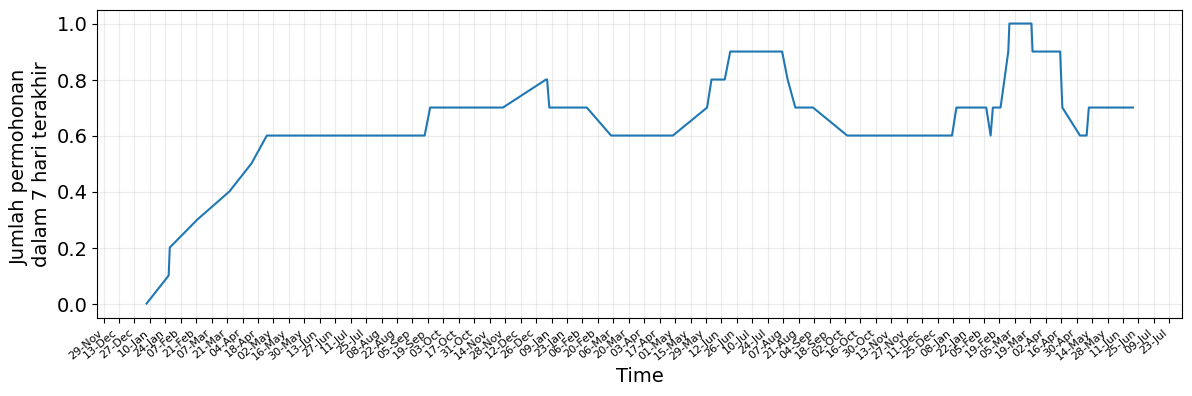

In [26]:
num_of_rows = 100
train_scale_df_e_selected = dataset["train_scale_df_g"]
plot_time_series(train_scale_df_e_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_e_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=True, use_year_locator=False)

#### Data Windowing

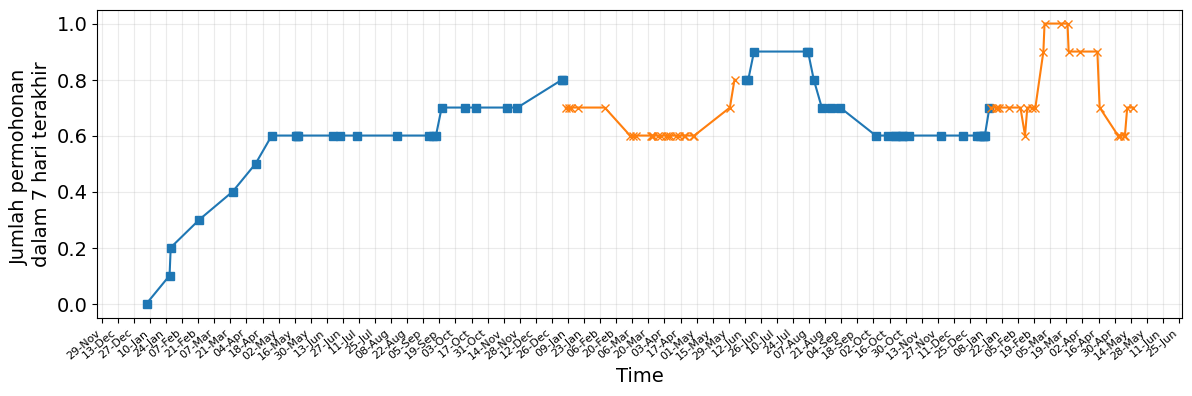

In [27]:
num_of_rows = 100
train_scale_df_e_selected = dataset["train_scale_df_g"]
plot_time_series_data_window(train_scale_df_e_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_e_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=True, use_year_locator=False)

## Model Development

In [28]:
def create_multivariate_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(sequence_length, len(X)):
        Xs.append(X[i-sequence_length:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [29]:
input_columns = [col for col in column_for_scaling if col != "rolling_7days"]
input_columns_autoreg = input_columns + ["rolling_7days"]

feature_col = "rolling_7days"

train_X = train_scale_df_g[input_columns].values
val_X = val_scale_df_g[input_columns].values
test_X = test_scale_df_g[input_columns].values

train_y = train_scale_df_g[feature_col].values
val_y = val_scale_df_g[feature_col].values
test_y = test_scale_df_g[feature_col].values

sequence_length = 10
X_train, y_train = create_multivariate_sequences(train_X, train_y, sequence_length)
X_val, y_val = create_multivariate_sequences(val_X, val_y, sequence_length)

In [30]:
# --- Model LSTM ---
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

c:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,289 (169.10 KB)

 Trainable params: 43,289 (169.10 KB)

 Non-trainable params: 0 (0.00 B)

### Data Training

epoch = 100

In [31]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - loss: 0.3979 - val_loss: 0.2419 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1267 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0655 - val_loss: 0.0530 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0634 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0418 - val_loss: 0.0783 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0477 - val_loss: 0.0773 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0481 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0369 - val_loss: 0.0466 - learning_rate: 5.0000e-04
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0324 - val_loss: 0.0436 - learning_rate: 5.0000e-04
Epoch 10/100
4/4 ━━

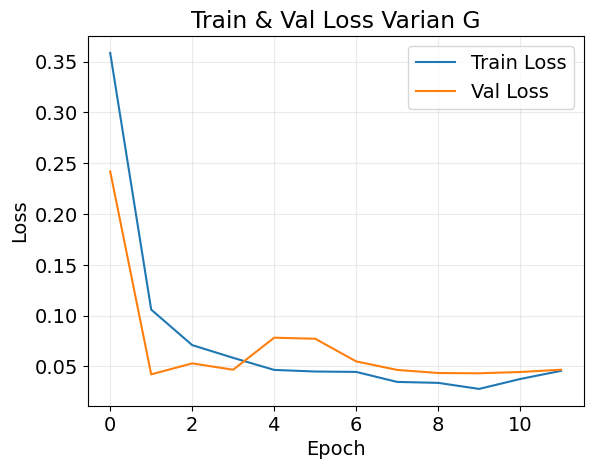

In [38]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train & Val Loss Varian G')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid("on")
plt.show()

### Prediksi `rolling 7 days`

In [33]:
# --- Fungsi Prediksi Autoregressive ---
# Ambil kolom yang digunakan sebagai input ke model
input_columns = [col for col in column_for_scaling if col != "rolling_7days"]

# Ambil sequence terakhir dari validation sebagai seed
last_sequence = val_scale_df_g[input_columns + ["rolling_7days"]].values[-sequence_length:].copy()

# Placeholder untuk menyimpan hasil prediksi (dalam skala yang sudah di-scale)
scaled_preds = []

# Autoregressive loop
for i in range(len(test_df)):
    # Pisahkan input features dan target dari last_sequence
    X_input = last_sequence[:, :-1]  # semua kolom kecuali rolling_7days (fitur input)
    X_input = X_input.reshape(1, sequence_length, len(input_columns))

    # Prediksi rolling_7days berikutnya
    pred_scaled = model.predict(X_input, verbose=0)[0][0]
    scaled_preds.append(pred_scaled)

    # Buat baris baru untuk update sequence
    next_row = last_sequence[-1].copy()
    next_row[:-1] = test_scale_df_g[input_columns].values[i]  # update input fitur
    next_row[-1] = pred_scaled  # rolling_7days hasil prediksi

    # Tambahkan ke sequence (geser window)
    last_sequence = np.vstack([last_sequence[1:], next_row])


In [34]:
# --- Inverse Scaling ---
# Konversi prediksi ke DataFrame agar bisa di-inverse scaling
preds_df_scaled = test_scale_df_g.iloc[:len(scaled_preds)].copy()
preds_df_scaled["rolling_7days"] = scaled_preds

# Inverse transform
preds_inverse = scaler_obj.inverse_transform(preds_df_scaled[column_for_scaling])[:, column_for_scaling.index("rolling_7days")]

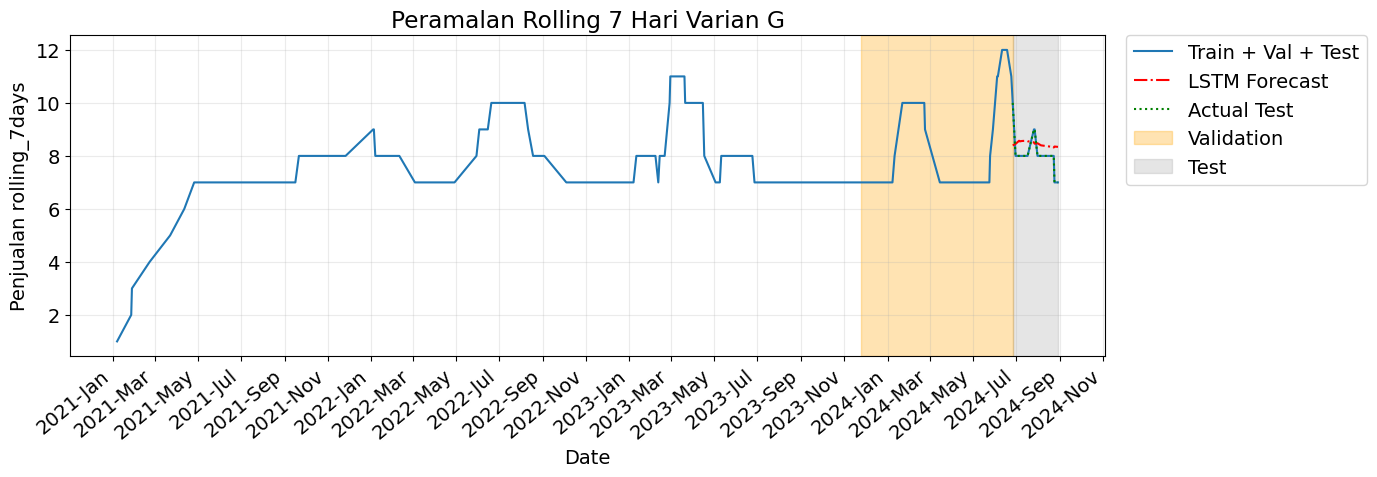

In [41]:
fig, ax = plt.subplots(figsize=(14, 5))

all_dates = pd.concat([train_df, val_df, test_df], ignore_index=True)['Tgl. Mohon']
rolling_values = pd.concat([train_df, val_df, test_df], ignore_index=True)['rolling_7days']

ax.plot(all_dates, rolling_values, label="Train + Val + Test")
ax.plot(test_df["Tgl. Mohon"], preds_inverse, "r-.", label="LSTM Forecast")
ax.plot(test_df["Tgl. Mohon"], test_df["rolling_7days"], "g:", label="Actual Test")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling_7days")
ax.set_title("Peramalan Rolling 7 Hari Varian G")
ax.grid("on")

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], test_df['Tgl. Mohon'].iloc[0], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
           color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    # label.set_fontsize(6)
    label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()

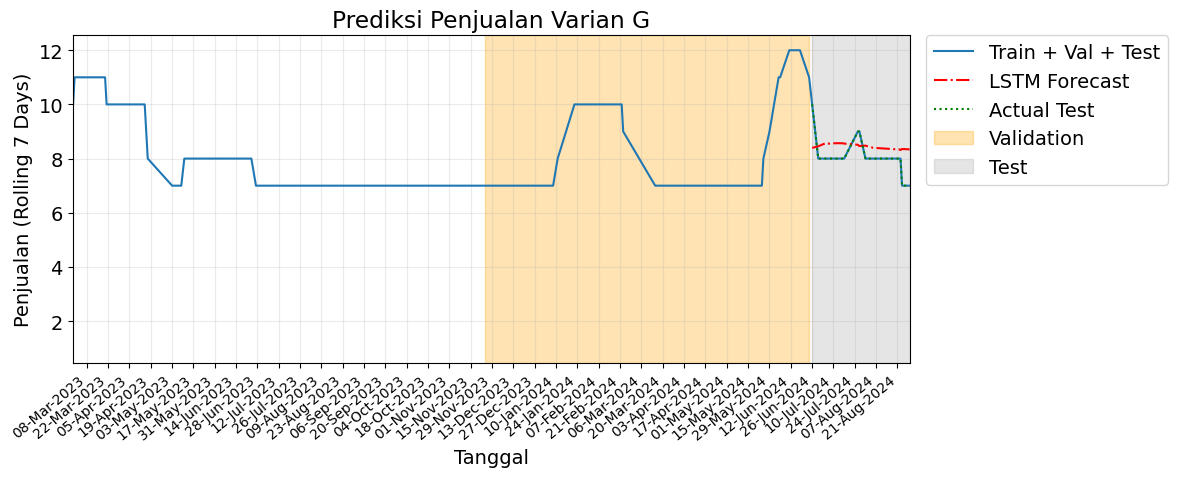

In [36]:
start_idx = 82

xlim = [all_dates.iloc[start_idx], test_df["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(all_dates, rolling_values, label="Train + Val + Test")
ax.plot(test_df["Tgl. Mohon"], preds_inverse, "r-.", label="LSTM Forecast")
ax.plot(test_df["Tgl. Mohon"], test_df["rolling_7days"], "g:", label="Actual Test")

formatter = mdates.DateFormatter("%d-%b-%Y")
locator = mdates.DayLocator(interval=14)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian G")
ax.grid("on")

# Area validation dan test
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
                    color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2, label="Test")

ax.set_xlim(xlim)
ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian G")
ax.grid("on")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_size(10)
    label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.tight_layout()
plt.show()


In [37]:
# --- Ground truth dan prediksi ---
y_true = test_df["rolling_7days"].values
y_pred = preds_inverse[:len(y_true)]  # pastikan sama panjangnya

# --- Evaluasi ---
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# --- MASE (Mean Absolute Scaled Error) ---
# Menggunakan MAE dari naive forecast (persistence model) sebagai pembagi
# Persistence: y_t ≈ y_{t-1}
naive_forecast = y_true[:-1]
actual = y_true[1:]

mae_naive = np.mean(np.abs(actual - naive_forecast))
mase = mae / mae_naive

print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MASE : {mase:.2f}")

MAE  : 0.65
MAPE : 8.07%
MSE  : 0.56
RMSE : 0.75
MASE : 2.08
